In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [325]:
# functions to redo phase 1
def get_outliers(column: pd.Series):
    lower_quartile = column.quantile(0.25)
    upper_quartile = column.quantile(0.75)
    iqr = upper_quartile - lower_quartile
    return column[(column < lower_quartile - 1.5*iqr) | (column > upper_quartile + 1.5*iqr)]
def iterative_reformat(processes_ptr: pd.DataFrame, connections_ptr: pd.DataFrame) -> pd.DataFrame:
    connections_ptr['ts'] = pd.to_datetime(connections_ptr['ts'])
    processes_ptr['ts'] = pd.to_datetime(processes_ptr['ts'])
    merged = processes_ptr.merge(connections_ptr, on=['ts', 'imei', 'mwra'], how='inner')
    merged['mwra'] = merged['mwra'].astype('int64')
    merged.drop(columns=['ts', 'imei'], inplace=True)
    to_drop = []
    # handle null values and outliers
    for column in merged.columns:
        # if more than 5% are NaN values or more than 5% are outliers, we don't use that column
        column_outliers = get_outliers(merged[column])
        if ((merged[column].isna().sum()/merged.shape[0] > 0.05) or 
            (column_outliers.shape[0] / merged.shape[0] > 0.05)):
            to_drop.append(column)
            continue
        # if there are some null values, we replace the data that's neutral in respect to mwra
        if merged[column].isnull().any():
            # we get means of the distributions for rows with present and non-present malware related activity
            means_per_mwra = merged.groupby('mwra')[column].mean()
            # we average those means, meaning the manufactured value won't be likely to affect predicted mwra 
            imputed_value = means_per_mwra.mean()
            merged[column].fillna(imputed_value, inplace=True)
        #  if there are any outliers, we replace them with the edge values. If we clipped all outliers, we would clutter way too much data together, so we clip only the most extreme ones
        if column_outliers.shape[0]:
            iqr = stats.iqr(merged[column])
            lower_limit = merged[column].quantile(0.25)  - 2.5 * iqr
            upper_limit = merged[column].quantile(0.75)  + 2.5 * iqr
            merged[column] = merged[column].clip(lower=lower_limit, upper=upper_limit)
    return merged.drop(columns=to_drop)
# functions to redo phase 2

In [326]:
# getting the data from previous phases
connections, processes, = pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''), pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''),
combined_table = iterative_reformat(processes, connections)

# JANKA added
columns_to_divide = combined_table.columns.difference(['mwra'])
combined_table[columns_to_divide] = combined_table[columns_to_divide].apply(lambda x: x / 2)
combined_table = combined_table.astype('int64') 

X = combined_table.drop(columns=['mwra'])
y = combined_table['mwra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Phase 3: Machine Learning

As we are dealing with continuous data, we will be using a different version of the ID3 algorithm opposed to the one shown in the lecture.  
Our implementation was inspired by the following implementation: https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/

In [327]:
def calculate_entropy(data):
    counts = np.bincount(data)
    probabilities = counts / len(data)
    return entropy(probabilities, base=2) # base=2 to use log2


class ID3classifier:
    class Node:
        def __init__(self, feature=None, result=None, value=None, left_child=None, right_child=None):
            self.feature: np.array = feature # column index of criteria being tested
            self.result: Union[0, 1] = result
            self.split_point: int = value
            self.left_child: Optional['ID3classifier.Node'] = left_child
            self.right_child: Optional['ID3classifier.Node'] = right_child
            
    def __init__(self, max_depth=None, min_samples_split=2, threshold=0):
        self.root: Optional['ID3classifier.Node'] = None
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.threshold: float = threshold
        
    def fit(self, data_samples: list[list[float]], target_values: list[int]):
        self.root = self._build(data_samples, target_values)
        
    def _build(self, X, y, depth=0):
        # going through halt conditions
        if (len(set(y)) == 1): # JANKA changed condition
            return self.Node(result=Counter(y).most_common(1)[0][0])
        
        best_entropy_gain = 0
        best_feature = None
        best_split_point = None
        features_length = X.shape[1]
        current_entropy = calculate_entropy(y)
        best_left_X, best_left_y, best_right_X, best_right_y = None, None, None, None
        for feature in range(features_length):
            #JANKA changed - we are looking for the best split point (= split with highest entropy gain)
            feature_values = set(X[:, feature])
            for split_point in feature_values:
                left_indices = X[:, feature] < split_point
                right_indices = X[:, feature] >= split_point
                left_X, left_y = X[left_indices], y[left_indices]
                right_X, right_y = X[right_indices], y[right_indices]
                left_entropy = calculate_entropy(left_y)
                right_entropy = calculate_entropy(right_y)
                left_p = len(left_y) / len(y)
                right_p = 1 - left_p
                entropy_gain = current_entropy - (left_p * left_entropy + right_p * right_entropy)
                if entropy_gain > best_entropy_gain:
                    best_entropy_gain = entropy_gain
                    best_feature = feature
                    best_split_point = split_point
                    best_left_X, best_left_y, best_right_X, best_right_y = left_X, left_y, right_X, right_y
                
        if best_entropy_gain > self.threshold:
            left_child = self._build(best_left_X, best_left_y, depth + 1)
            right_child = self._build(best_right_X, best_right_y, depth + 1)
            return self.Node(feature=best_feature, value=best_split_point ,left_child=left_child, right_child=right_child)
        
        # if no split found, return the most common label by default
        return self.Node(result=Counter(y).most_common(1)[0][0])
    
    def predict(self, item):
        if self.root is None:
            raise ValueError('The model has not been trained yet.')
            
        # the depth has to be at least 2, including root
        if self.root.left_child is None and self.root.right_child is None:
            return None
        return self._predict(self.root, item)
        
    def _predict(self, node, item):
        if node.result is not None:
            return node.result
        if item[node.feature] < node.split_point:
            return self._predict(node.left_child, item)
        return self._predict(node.right_child, item)
        

In [328]:
classifier = ID3classifier()
classifier.fit(X_train.values, y_train.values)

In [329]:
y_pred_test = np.array([classifier.predict(item) for item in X_test.values])
y_pred_train = np.array([classifier.predict(item) for item in X_train.values])

Train score, test score:

In [330]:
accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(1.0, 0.8458049886621315)

In [331]:
precision_score(y_train, y_pred_train, average=None), precision_score(y_test, y_pred_test, average=None)

(array([1., 1.]), array([0.78894472, 0.88166931]))

In [332]:
recall_score(y_train, y_pred_train, average=None), recall_score(y_test, y_pred_test, average=None)

(array([1., 1.]), array([0.80789022, 0.86881832]))

In [333]:
f1_score(y_train, y_pred_train, average=None), f1_score(y_test, y_pred_test, average=None)

(array([1., 1.]), array([0.79830508, 0.87519664]))

The model may be overfitting to the training data, because the model achieved an accuracy of 100% on the training set, which typically suggests that the model has learned the training data too well, but on the test set, there is a significantly lower accuracy.

## 3.2

### A

In [334]:
myTree = tree.DecisionTreeClassifier()
myTree = myTree.fit(X_train, y_train)
y_pred_tree = myTree.predict(X_test)

In [335]:
tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_precision = precision_score(y_test, y_pred_tree, average='binary')
tree_recall = recall_score(y_test, y_pred_tree, average='binary')
tree_f1 = f1_score(y_test, y_pred_tree, average='binary')

### B

In [336]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
y_pred_regression = logistic_regression.predict(X_test)

In [337]:
logistic_accuracy = accuracy_score(y_test, y_pred_regression)
logistic_precision = precision_score(y_test, y_pred_regression, average='binary')
logistic_recall = recall_score(y_test, y_pred_regression, average='binary')
logistic_f1 = f1_score(y_test, y_pred_regression, average='binary')

In [338]:
print(f'Logistic Regression - Accuracy: {logistic_accuracy}, Precision: {logistic_precision}, Recall: {logistic_recall}, F1 Score: {logistic_f1}')
print(f'Decision Tree - Accuracy: {tree_accuracy}, Precision: {tree_precision}, Recall: {tree_recall}, F1 Score: {tree_f1}')

Logistic Regression - Accuracy: 0.9096209912536443, Precision: 0.909272183449651, Recall: 0.9495054659031754, F1 Score: 0.9289533995416348
Decision Tree - Accuracy: 0.8461289277615808, Precision: 0.8793284365162645, Recall: 0.8724622592399792, F1 Score: 0.87588189182127


Logistická regresia mala lepšiu presnosť

### C, E

In [339]:
y_pred_test = np.array([classifier.predict(item) for item in X_test.values])
y_pred_train = np.array([classifier.predict(item) for item in X_train.values])

id3_accuracy = accuracy_score(y_test, y_pred_test)
id3_precision = precision_score(y_test, y_pred_test, average='binary')
id3_recall = recall_score(y_test, y_pred_test, average='binary')
id3_f1 = f1_score(y_test, y_pred_test, average='binary')

In [340]:
print("Logistic Regression - Accuracy:", logistic_accuracy, "Precision:", logistic_precision, "Recall:", logistic_recall, "F1 Score:", logistic_f1)
print("Decision Tree - Accuracy:", tree_accuracy, "Precision:", tree_precision, "Recall:", tree_recall, "F1 Score:", tree_f1)
print("ID3 Classifier - Accuracy:", id3_accuracy, "Precision:", id3_precision, "Recall:", id3_recall, "F1 Score:", id3_f1)

Logistic Regression - Accuracy: 0.9096209912536443 Precision: 0.909272183449651 Recall: 0.9495054659031754 F1 Score: 0.9289533995416348
Decision Tree - Accuracy: 0.8461289277615808 Precision: 0.8793284365162645 Recall: 0.8724622592399792 F1 Score: 0.87588189182127
ID3 Classifier - Accuracy: 0.8458049886621315 Precision: 0.8816693079767565 Recall: 0.8688183237896928 F1 Score: 0.8751966439433665


Logistická regresia má najlepšiu presnosť z vyššie vyskúšaných klasifikátorov.

### D - toto podla mna neni spravne

[Text(0.4152641558037609, 0.9852941176470589, 'x[1] <= 4.5\ngini = 0.466\nsamples = 12345\nvalue = [4566, 7779]'),
 Text(0.09061926952102653, 0.9558823529411765, 'x[20] <= 3.5\ngini = 0.217\nsamples = 6735\nvalue = [832, 5903]'),
 Text(0.25294171266239374, 0.9705882352941178, 'True  '),
 Text(0.01711062994651311, 0.9264705882352942, 'x[3] <= 4.5\ngini = 0.435\nsamples = 307\nvalue = [209.0, 98.0]'),
 Text(0.009107270777982785, 0.8970588235294118, 'x[22] <= 3.5\ngini = 0.375\nsamples = 76\nvalue = [19, 57]'),
 Text(0.008003359168530327, 0.8676470588235294, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.010211182387435243, 0.8676470588235294, 'x[2] <= 6.5\ngini = 0.236\nsamples = 66\nvalue = [9, 57]'),
 Text(0.007175425461440982, 0.8382352941176471, 'x[12] <= 40.5\ngini = 0.198\nsamples = 63\nvalue = [7, 56]'),
 Text(0.004415646437809835, 0.8088235294117647, 'x[9] <= 34.0\ngini = 0.078\nsamples = 49\nvalue = [2.0, 47.0]'),
 Text(0.0022078232189049174, 0.7794117647058824, 'x[24] <=

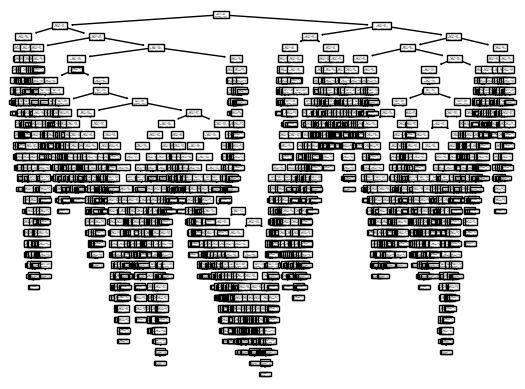

In [341]:
tree.plot_tree(myTree)

## 3.3

### A

In [348]:
def test_regression(X_train, y_train, X_test, y_test, c, solver, penalty, max_iter, class_weight):
    logistic_regression = LogisticRegression(C=c, solver=solver, penalty=penalty, max_iter=max_iter, class_weight=class_weight)
    logistic_regression.fit(X_train, y_train)
    y_pred_regression = logistic_regression.predict(X_test)

    logistic_accuracy = accuracy_score(y_test, y_pred_regression)
    logistic_precision = precision_score(y_test, y_pred_regression, average='binary')
    logistic_recall = recall_score(y_test, y_pred_regression, average='binary')
    logistic_f1 = f1_score(y_test, y_pred_regression, average='binary')

    print(round(logistic_accuracy, 6), "\t", round(logistic_precision, 6), "\t", round(logistic_recall, 6), "\t", round(logistic_f1, 6))

In [354]:
test_regression(X_train, y_train, X_test, y_test, 0.01, 'lbfgs', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'lbfgs', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 1.0, 'lbfgs', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 10, 'lbfgs', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 100, 'lbfgs', 'l2', 500, None)


0.909621 	 0.908865 	 0.950026 	 0.92899
0.910269 	 0.909771 	 0.950026 	 0.929463
0.909621 	 0.909272 	 0.949505 	 0.928953
0.909945 	 0.909726 	 0.949505 	 0.92919
0.909621 	 0.909272 	 0.949505 	 0.928953


Best result for parameter c is 0.1, so we will continue with this value 

In [ ]:
test_regression(X_train, y_train, X_test, y_test, 0.1, 'lbfgs', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'newton-cg', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'newton-cholesky', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'sag', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'saga', 'l2', 500, None)

0.910269 	 0.909771 	 0.950026 	 0.929463
0.911565 	 0.912412 	 0.948985 	 0.930339
0.910269 	 0.909771 	 0.950026 	 0.929463
0.910269 	 0.909771 	 0.950026 	 0.929463
0.910593 	 0.911868 	 0.947944 	 0.929556
0.910593 	 0.911868 	 0.947944 	 0.929556


Best result for parameter solver is liblinear, so we will continue with this value 

In [358]:
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l1', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 500, None)

0.911565 	 0.912826 	 0.948464 	 0.930304
0.911565 	 0.912412 	 0.948985 	 0.930339


More results were better with penalty set to l2, so we will continue with this value.

In [360]:
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 500, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 200, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 1000, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 5000, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 10000, None)

0.911565 	 0.912412 	 0.948985 	 0.930339
0.911565 	 0.912412 	 0.948985 	 0.930339
0.911565 	 0.912412 	 0.948985 	 0.930339
0.911565 	 0.912412 	 0.948985 	 0.930339
0.911565 	 0.912412 	 0.948985 	 0.930339


There is no impact on result when changing the max_iter parameter, so we will continue with value 1000 (we cannot use the default value since it supports less iteration than we need). 

In [361]:
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 1000, None)
test_regression(X_train, y_train, X_test, y_test, 0.1, 'liblinear', 'l2', 1000, 'balanced')

0.911565 	 0.912412 	 0.948985 	 0.930339
0.906058 	 0.921012 	 0.928683 	 0.924832


The results were better with class_weight set to default value (None).

### B

In [369]:
logistic_regression = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None) # algorithm with best hyperparameters

bagging_classifier = BaggingClassifier(estimator=logistic_regression, n_estimators=10, random_state=42)
bagging_classifier.fit(X_train, y_train)
y_pred = bagging_classifier.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_pred)
bagging_precision = precision_score(y_test, y_pred, average='binary')
bagging_recall = recall_score(y_test, y_pred, average='binary')
bagging_f1 = f1_score(y_test, y_pred, average='binary')

In [393]:
adaboost_classifier = AdaBoostClassifier(estimator=logistic_regression, n_estimators=50, random_state=42)
adaboost_classifier.fit(X_train, y_train)
y_pred = adaboost_classifier.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, y_pred)
adaboost_precision = precision_score(y_test, y_pred, average='binary')
adaboost_recall = recall_score(y_test, y_pred, average='binary')
adaboost_f1 = f1_score(y_test, y_pred, average='binary')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [380]:
base_learners = [
    ('lr', LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)),
    ('dt', tree.DecisionTreeClassifier()),
    ('svm', SVC(probability=True))
]
meta_learner = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

stacking1_accuracy = accuracy_score(y_test, y_pred)
stacking1_precision = precision_score(y_test, y_pred, average='binary')
stacking1_recall = recall_score(y_test, y_pred, average='binary')
stacking1_f1 = f1_score(y_test, y_pred, average='binary')

In [381]:
base_learners = [
    ('dt', tree.DecisionTreeClassifier()),
    ('lr', LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)),
    ('svm', SVC(probability=True))
]
meta_learner = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

stacking2_accuracy = accuracy_score(y_test, y_pred)
stacking2_precision = precision_score(y_test, y_pred, average='binary')
stacking2_recall = recall_score(y_test, y_pred, average='binary')
stacking2_f1 = f1_score(y_test, y_pred, average='binary')

In [382]:
base_learners = [
    ('svm', SVC(probability=True)),
    ('dt', tree.DecisionTreeClassifier()),
    ('lr', LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None))
]
meta_learner = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

stacking3_accuracy = accuracy_score(y_test, y_pred)
stacking3_precision = precision_score(y_test, y_pred, average='binary')
stacking3_recall = recall_score(y_test, y_pred, average='binary')
stacking3_f1 = f1_score(y_test, y_pred, average='binary')

In [384]:
base_learners = [
    ('lr', LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)),
    ('svm', SVC(probability=True)),
    ('dt', tree.DecisionTreeClassifier())
]
meta_learner = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

stacking4_accuracy = accuracy_score(y_test, y_pred)
stacking4_precision = precision_score(y_test, y_pred, average='binary')
stacking4_recall = recall_score(y_test, y_pred, average='binary')
stacking4_f1 = f1_score(y_test, y_pred, average='binary')

In [385]:
base_learners = [
    ('dt', tree.DecisionTreeClassifier()),
    ('svm', SVC(probability=True)),
    ('lr', LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)),
]
meta_learner = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

stacking5_accuracy = accuracy_score(y_test, y_pred)
stacking5_precision = precision_score(y_test, y_pred, average='binary')
stacking5_recall = recall_score(y_test, y_pred, average='binary')
stacking5_f1 = f1_score(y_test, y_pred, average='binary')

In [386]:
base_learners = [
    ('svm', SVC(probability=True)),
    ('lr', LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)),
    ('dt', tree.DecisionTreeClassifier())
]
meta_learner = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000, class_weight=None)
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

stacking6_accuracy = accuracy_score(y_test, y_pred)
stacking6_precision = precision_score(y_test, y_pred, average='binary')
stacking6_recall = recall_score(y_test, y_pred, average='binary')
stacking6_f1 = f1_score(y_test, y_pred, average='binary')

In [394]:
print("Bagging:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(bagging_accuracy, bagging_precision, bagging_recall, bagging_f1))
print("AdaBoost:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1))
print("Stacking1:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(stacking1_accuracy, stacking1_precision, stacking1_recall, stacking1_f1))
print("Stacking2:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(stacking2_accuracy, stacking2_precision, stacking2_recall, stacking2_f1))
print("Stacking3:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(stacking3_accuracy, stacking3_precision, stacking3_recall, stacking3_f1))
print("Stacking4:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(stacking4_accuracy, stacking4_precision, stacking4_recall, stacking4_f1))
print("Stacking5:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(stacking5_accuracy, stacking5_precision, stacking5_recall, stacking5_f1))
print("Stacking6:\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(stacking6_accuracy, stacking6_precision, stacking6_recall, stacking6_f1))

Bagging:	0.910593	0.912694	0.946903	0.929484
AdaBoost:	0.907353	0.906514	0.948985	0.927263
Stacking1:	0.910593	0.911456	0.948464	0.929592
Stacking2:	0.910917	0.911089	0.949505	0.929901
Stacking3:	0.911565	0.912000	0.949505	0.930375
Stacking4:	0.911565	0.912000	0.949505	0.930375
Stacking5:	0.912213	0.912088	0.950547	0.930920
Stacking6:	0.911889	0.912044	0.950026	0.930648


The best results were when stacking was used with the order: DecisionTreeClassifier, SVC, LogisticRegression.

### C

In [ ]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

cv_results = cross_validate(logistic_regression, X_train, y_train, cv=5, scoring=scoring)
